In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os   # handling the files
import pickle # storing numpy features
import numpy as np
from tqdm.notebook import tqdm # how much data is process till now

from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input # extract features from image data.
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

In [3]:
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/flickr_data"
WORKING_DIR = '/content/drive/MyDrive/flickr8k_working'

In [4]:
# Load vgg16 Model
model = VGG16()

# restructure model
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)

# Summerize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [6]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [7]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [8]:
len(mapping)

8091

In [9]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3802969776.py:12: SyntaxWarning: invalid escape sequence '\s'
  caption = caption.replace('\s+', ' ')


In [10]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [11]:
# preprocess the text
clean(mapping)
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [12]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [13]:
len(all_captions)

40455

In [14]:
import pandas as pd

data = []
for img_id, captions in mapping.items():
    for cap in captions:
        data.append([img_id, cap])

df = pd.DataFrame(data, columns=["image", "caption"])
print(df.head())


                   image                                            caption
0  1000268201_693b08cb0e  startseq child in pink dress is climbing up se...
1  1000268201_693b08cb0e    startseq girl going into wooden building endseq
2  1000268201_693b08cb0e  startseq little girl climbing into wooden play...
3  1000268201_693b08cb0e  startseq little girl climbing the stairs to he...
4  1000268201_693b08cb0e  startseq little girl in pink dress going into ...


In [15]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [16]:
vocab_size

8485

In [17]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [18]:
import pandas as pd
import numpy as np

# -------------------
# 1. بناء DataFrame من mapping
# -------------------
data = []
for img_id, captions in mapping.items():
    for cap in captions:
        data.append([img_id, cap])

df = pd.DataFrame(data, columns=["image", "caption"])

# -------------------
# 2. تقسيم الصور train / val / test
# -------------------
image_ids = list(mapping.keys())
np.random.shuffle(image_ids)   # shuffle قبل التقسيم

n_total = len(image_ids)
n_train = int(n_total * 0.7)
n_val   = int(n_total * 0.15)

train_ids = image_ids[:n_train]
val_ids   = image_ids[n_train:n_train+n_val]
test_ids  = image_ids[n_train+n_val:]

# -------------------
# 3. بناء DataFrames منفصلة
# -------------------
train_df = df[df["image"].isin(train_ids)].reset_index(drop=True)
val_df   = df[df["image"].isin(val_ids)].reset_index(drop=True)
test_df  = df[df["image"].isin(test_ids)].reset_index(drop=True)

print("Total images:", len(image_ids))
print("Train images:", len(train_ids))
print("Val images:", len(val_ids))
print("Test images:", len(test_ids))


Total images: 8091
Train images: 5663
Val images: 1213
Test images: 1215


In [20]:
import numpy as np
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

class CustomDataGenerator(Sequence):
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features, shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self, batch):
        X1, X2, y = list(), list(), list()
        images = batch[self.X_col].tolist()

        for image in images:
            if image not in self.features:  # 🔹 حماية من الصور الناقصة
                continue

            feature = self.features[image][0]
            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()

            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        return np.array(X1), np.array(X2), np.array(y)


In [23]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)
print("عدد الصور في features:", len(features))
some_key = list(features.keys())[0]
print("مثال:", some_key, features[some_key].shape)


عدد الصور في features: 8091
مثال: 378453580_21d688748e (1, 4096)


In [24]:
some_key = list(mapping.keys())[0]
print("مثال من mapping:", some_key)
print("موجود في features؟", some_key in features)


مثال من mapping: 1000268201_693b08cb0e
موجود في features؟ True


In [29]:
train_gen = CustomDataGenerator(
    df=train_df,
    X_col="image",
    y_col="caption",
    batch_size=32,
    directory=None,
    tokenizer=tokenizer,
    vocab_size=len(tokenizer.word_index) + 1,
    max_length=max_length,
    features=features,
    shuffle=True
)

val_gen = CustomDataGenerator(
    df=val_df,
    X_col="image",
    y_col="caption",
    batch_size=32,
    directory=None,
    tokenizer=tokenizer,
    vocab_size=len(tokenizer.word_index) + 1,
    max_length=max_length,
    features=features,
    shuffle=False
)

test_gen = CustomDataGenerator(
    df=test_df,
    X_col="image",
    y_col="caption",
    batch_size=32,
    directory=None,
    tokenizer=tokenizer,
    vocab_size=len(tokenizer.word_index) + 1,
    max_length=max_length,
    features=features,
    shuffle=False
)


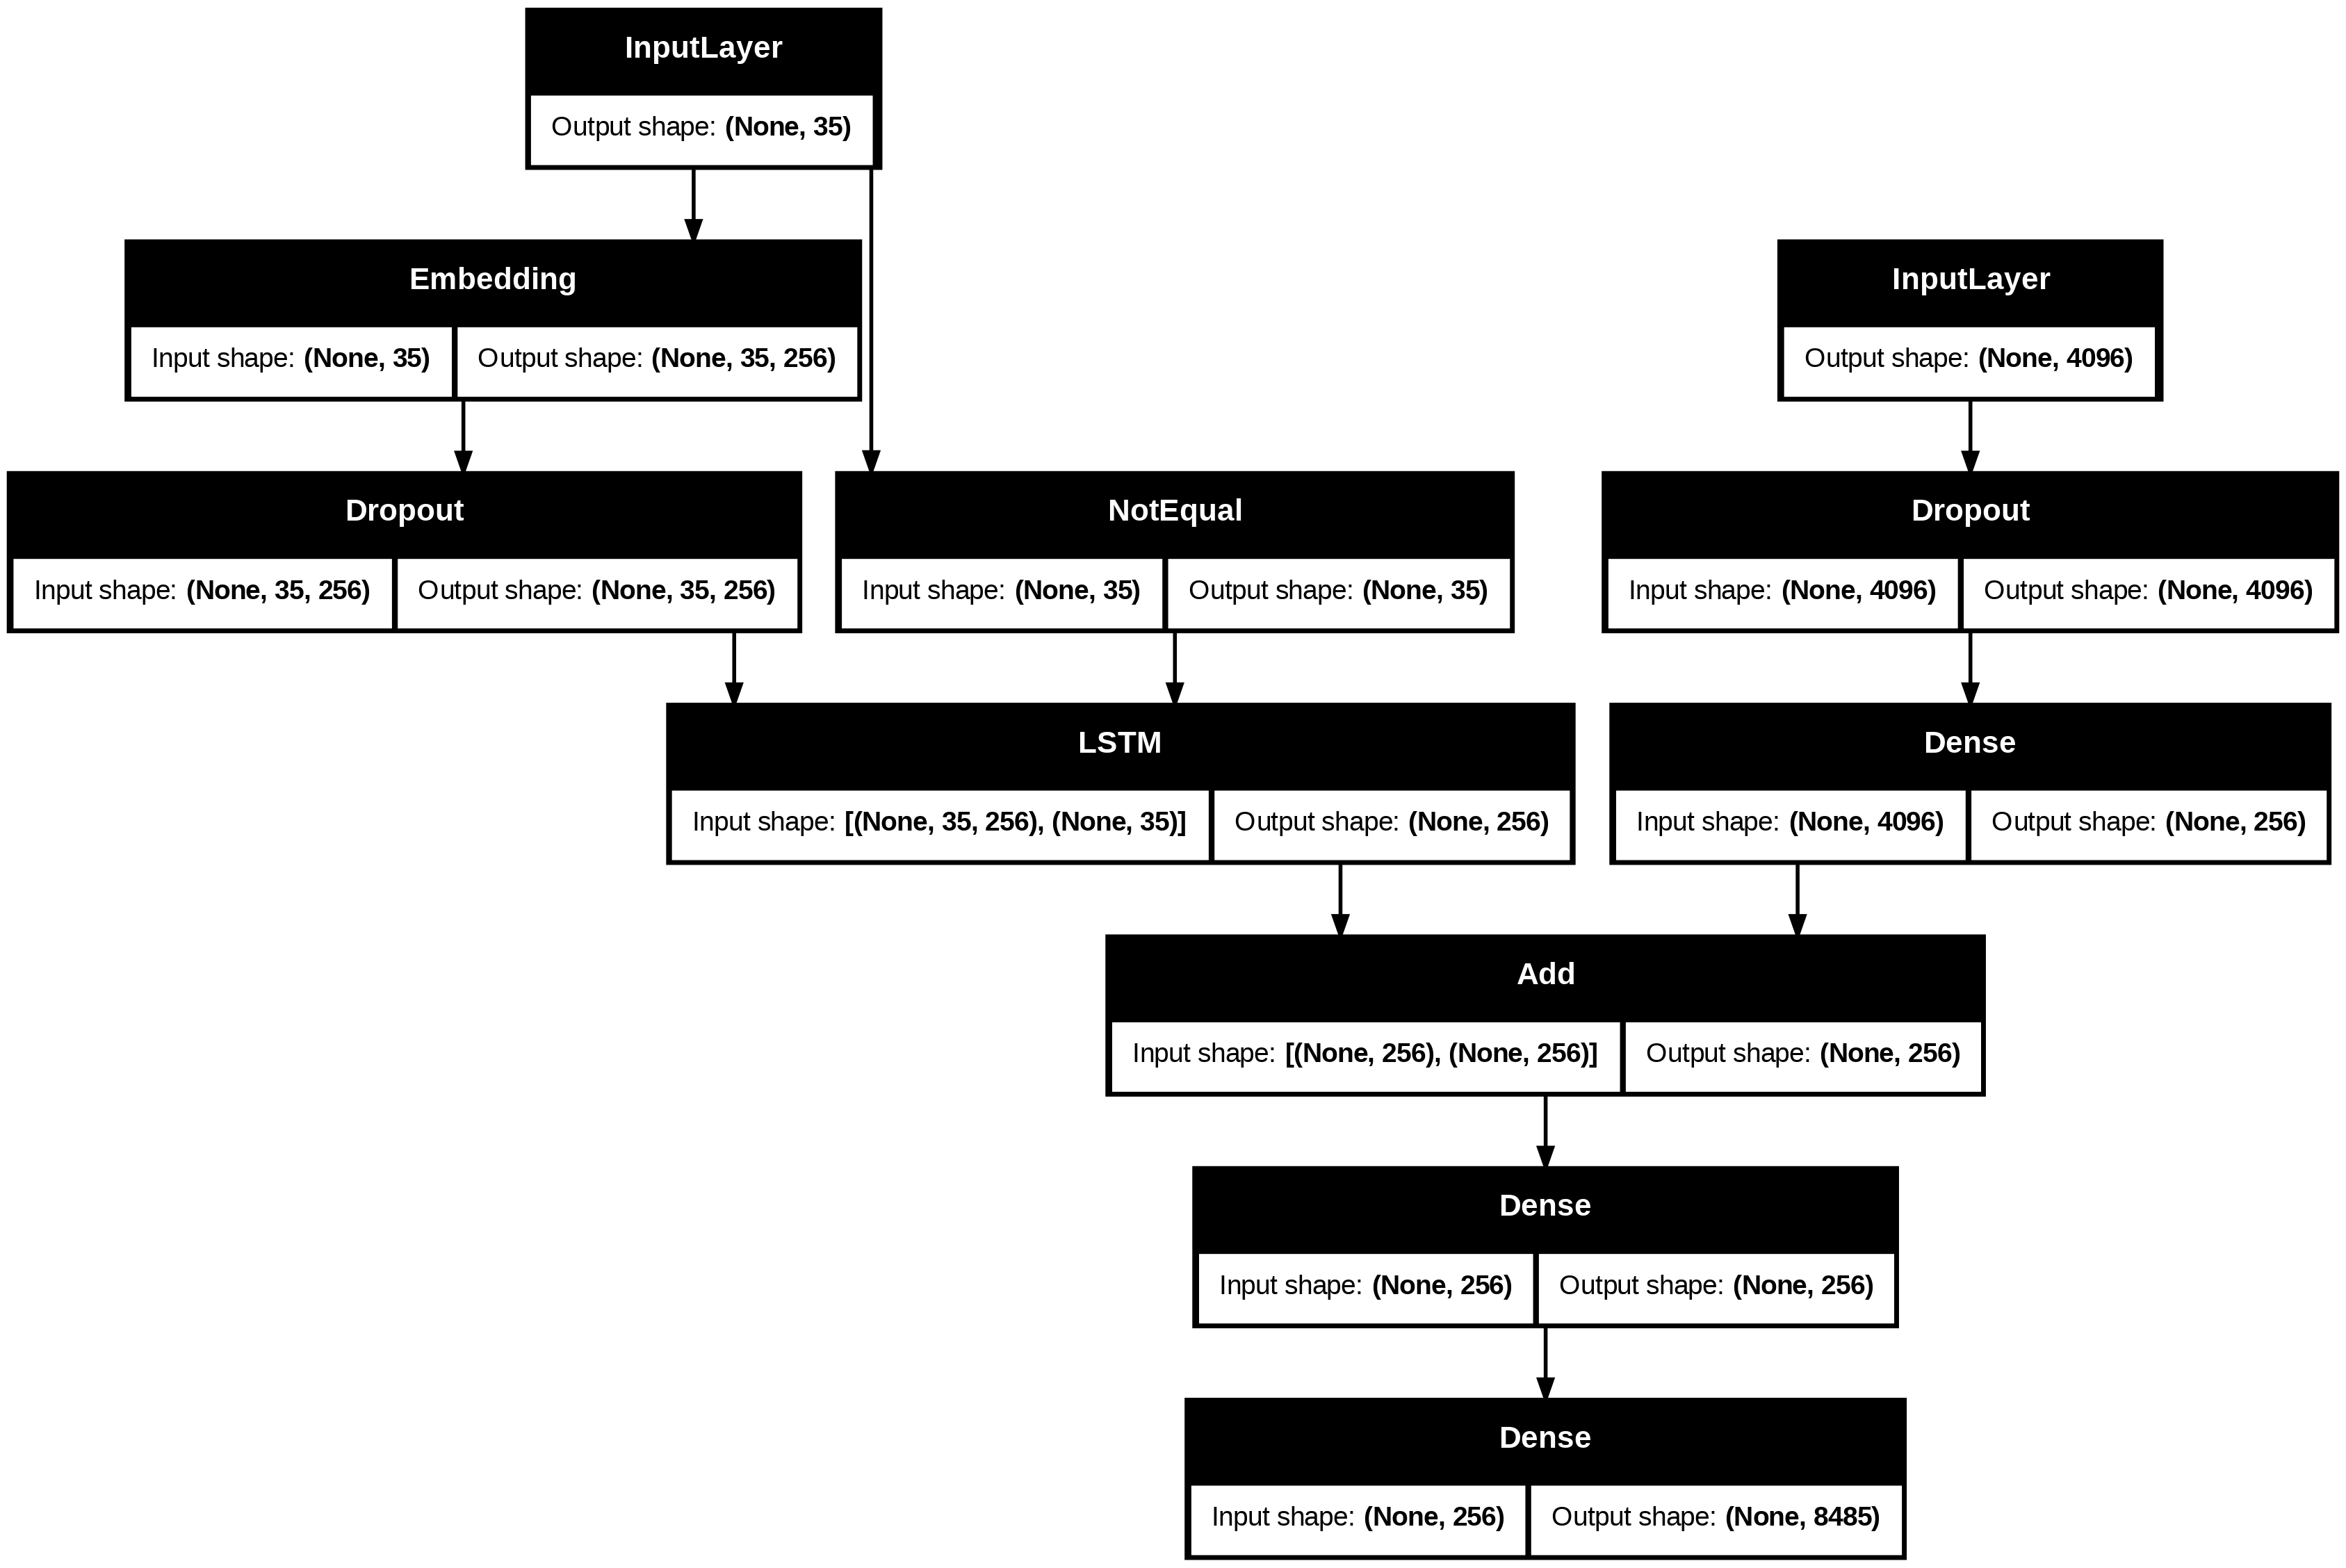

In [26]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# -----------------------
# 1. حفظ أفضل نموذج
# -----------------------
checkpoint = ModelCheckpoint(
    "best_model.h5",          # اسم الملف
    monitor="val_loss",       # المراقبة على خسارة التحقق
    verbose=1,
    save_best_only=True,
    mode="min"
)

# -----------------------
# 2. إيقاف مبكر
# -----------------------
earlystop = EarlyStopping(
    monitor="val_loss",
    patience=3,               # عدد الإيبوكات بدون تحسن قبل الإيقاف
    verbose=1,
    restore_best_weights=True
)

# -----------------------
# 3. تخفيض معدل التعلم
# -----------------------
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,               # يقلل LR للنصف
    patience=2,               # إذا لم يتحسن بعد 3 إيبوكات
    verbose=1,
    min_lr=1e-6
)

# -----------------------
# التدريب مع callbacks
# -----------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=[checkpoint, earlystop, reduce_lr]
)


Epoch 1/50
884/884 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1941 - loss: 4.7722
Epoch 1: val_loss improved from inf to 3.93002, saving model to best_model.h5


884/884 ━━━━━━━━━━━━━━━━━━━━ 1528s 2s/step - accuracy: 0.1942 - loss: 4.7718 - val_accuracy: 0.2791 - val_loss: 3.9300 - learning_rate: 0.0010
Epoch 2/50
884/884 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2949 - loss: 3.5713
Epoch 2: val_loss improved from 3.93002 to 3.75243, saving model to best_model.h5


884/884 ━━━━━━━━━━━━━━━━━━━━ 1541s 2s/step - accuracy: 0.2949 - loss: 3.5712 - val_accuracy: 0.2986 - val_loss: 3.7524 - learning_rate: 0.0010
Epoch 3/50
884/884 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3293 - loss: 3.1726
Epoch 3: val_loss improved from 3.75243 to 3.73082, saving model to best_model.h5


884/884 ━━━━━━━━━━━━━━━━━━━━ 1538s 2s/step - accuracy: 0.3293 - loss: 3.1726 - val_accuracy: 0.3055 - val_loss: 3.7308 - learning_rate: 0.0010
Epoch 4/50
884/884 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3514 - loss: 2.9173
Epoch 4: val_loss did not improve from 3.73082
884/884 ━━━━━━━━━━━━━━━━━━━━ 1512s 2s/step - accuracy: 0.3514 - loss: 2.9173 - val_accuracy: 0.3117 - val_loss: 3.7798 - learning_rate: 0.0010
Epoch 5/50
884/884 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3710 - loss: 2.7137
Epoch 5: val_loss did not improve from 3.73082

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
884/884 ━━━━━━━━━━━━━━━━━━━━ 1507s 2s/step - accuracy: 0.3710 - loss: 2.7137 - val_accuracy: 0.3121 - val_loss: 3.8642 - learning_rate: 0.0010
Epoch 6/50
884/884 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4005 - loss: 2.4803
Epoch 6: val_loss did not improve from 3.73082
884/884 ━━━━━━━━━━━━━━━━━━━━ 1534s 2s/step - accuracy: 0.4005 - loss: 2.4803 - val_accuracy: 0.315

In [31]:
loss, acc = model.evaluate(test_gen)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")


189/189 ━━━━━━━━━━━━━━━━━━━━ 422s 2s/step - accuracy: 0.3125 - loss: 3.7589
Test Loss: 3.7788
Test Accuracy: 0.3091


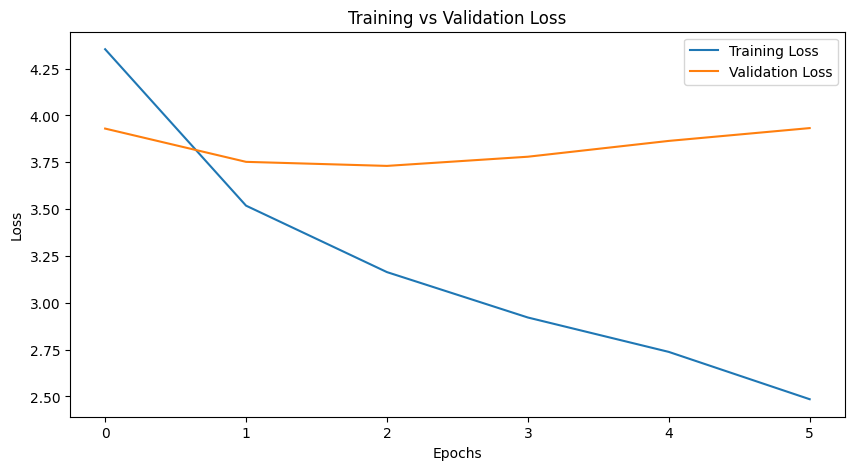

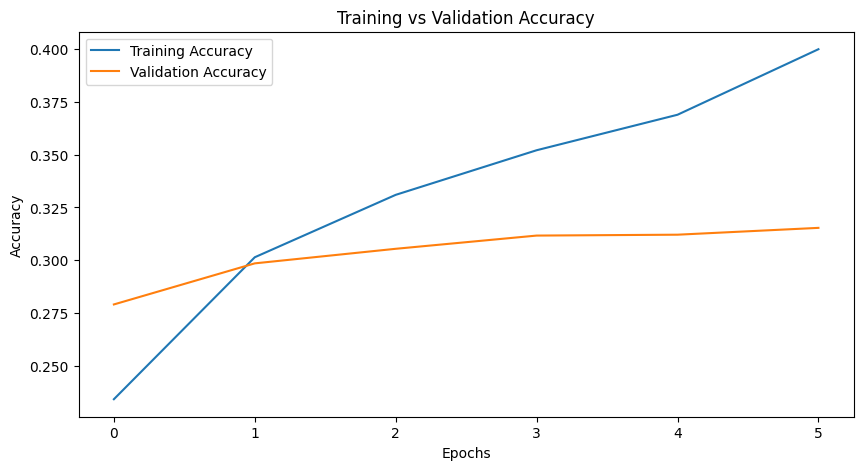

In [32]:
import matplotlib.pyplot as plt

# نفترض إنك خزنت سجل التدريب في متغير اسمه history
# مثل: history = model.fit(...)

def plot_training_history(history):
    # 🎯 خسارة التدريب والتحقق
    plt.figure(figsize=(10,5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.show()

    # 🎯 دقة التدريب والتحقق (إذا كنتِ ضايفة metrics=["accuracy"])
    if 'accuracy' in history.history:
        plt.figure(figsize=(10,5))
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training vs Validation Accuracy')
        plt.legend()
        plt.show()

# استدعاء الدالة
plot_training_history(history)


In [33]:
def generate_caption(model, tokenizer, photo, max_length):
    # ابدأ بالكلمة <start>
    in_text = 'startseq'

    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)   # الكلمة المتوقعة

        # حول رقم → كلمة
        word = None
        for w, index in tokenizer.word_index.items():
            if index == yhat:
                word = w
                break

        if word is None:
            break
        in_text += ' ' + word

        if word == 'endseq':
            break

    return in_text


In [35]:
# اختر صورة من test set
test_image_id= "439492931_a96d590e40"

print("صورة تجريبية:", test_image_id)

# استرجع ميزات الصورة
photo_feature = features[test_image_id]  # شكلها (1, 4096)

# توليد الكابشن
caption = generate_caption(model, tokenizer, photo_feature, max_length)
print("Generated Caption:", caption)


صورة تجريبية: 439492931_a96d590e40
Generated Caption: startseq two dogs are running through the grass endseq


In [36]:
# اختر صورة من test set
test_image_id= "494907021_321e82877a"

print("صورة تجريبية:", test_image_id)

# استرجع ميزات الصورة
photo_feature = features[test_image_id]  # شكلها (1, 4096)

# توليد الكابشن
caption = generate_caption(model, tokenizer, photo_feature, max_length)
print("Generated Caption:", caption)


صورة تجريبية: 494907021_321e82877a
Generated Caption: startseq two people are standing on the sidewalk endseq
